# Take subsamples of training set to estimate learning curve.

In [2]:
import os
import sys
import datetime
import pandas as pd
import pickle as pkl
import numpy as np
import scipy

%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('/code')
from edge import data
from edge import patient_stays
from edge import diagnosis
from edge import meds
from edge import vitals
from edge import utils
from edge import demographics
from edge import stays
from edge import notes
from edge import perf_utils

In [4]:
data_dict = data.load_raw_data_from_files('/data/raw')

Loading demographics data from /data/raw...
Loading census data from /data/raw...
Loading transfers data from /data/raw...
Loading diagnoses data from /data/raw...
Loading meds data from /data/raw...
Loading vitals data from /data/raw...
Loading orders data from /data/raw...
Loading lab_results data from /data/raw...
Loading alerts data from /data/raw...
Loading progress_notes data from /data/raw...
Loading stays data from /data/raw...


In [5]:
with open("/data/processed/prediction_times.pkl", 'rb') as f_in: 
    prediction_times = pkl.load(f_in)
prediction_times.shape

(10880004, 4)

In [6]:
# Load prior prediction times and features. 
with open('/data/processed/feature_colnames.pkl', 'rb') as f_in: 
    feature_names = pkl.load(f_in)

features = scipy.sparse.load_npz('/data/processed/features_csr.npz')
features

<10880004x3677 sparse matrix of type '<class 'numpy.float32'>'
	with 355415944 stored elements in Compressed Sparse Row format>

In [7]:
demo_features = scipy.sparse.load_npz('/data/processed/demo_features_csr.npz')
stay_features = scipy.sparse.load_npz('/data/processed/stay_features_csr.npz')
mean_note_features = scipy.sparse.load_npz('/data/processed/mean_note_embeddings_csr.npz')
max_note_features = scipy.sparse.load_npz('/data/processed/max_note_embeddings_csr.npz')
print('Done')

Done


In [8]:
all_features = scipy.sparse.hstack([features, demo_features, stay_features, mean_note_features, max_note_features])

In [9]:
# hstack returns a coo matrix, so convert back to csr. 
features = scipy.sparse.csr_matrix(all_features)
features

<10880004x4488 sparse matrix of type '<class 'numpy.float32'>'
	with 1302959335 stored elements in Compressed Sparse Row format>

## Assign target values.
4 day rehosp.

In [10]:
# Assign targets
stays = data_dict['stays']

indices = prediction_times.StayRowIndex.values
dates_of_transfer = stays.DateOfTransfer.dt.date.values[indices]
prediction_dates = prediction_times.PredictionTimestamp.dt.date.values
time_diffs = [ transfer_date - predict_date for transfer_date, predict_date in zip(dates_of_transfer, prediction_dates)]
time_diffs_in_days = [diff.days if type(diff) is datetime.timedelta else 1e6 for diff in time_diffs]

time_diffs_in_days = np.array(time_diffs_in_days)
print(np.sum(time_diffs_in_days <= 4))
print(np.mean(time_diffs_in_days <= 4))

mask = (time_diffs_in_days <= 4)
target = np.zeros(len(time_diffs_in_days))
target[mask] = 1
print(np.mean(target))


143701
0.013207807644188366
0.013207807644188366


## Do splits into train, val, test. 

In [11]:
train_start_date = '2017-01-01'
train_end_date = '2019-07-31'
val_end_date = '2019-11-30'
test_end_date = '2020-02-28'

### Deal with lookback period for stays features... 
We do a 90 day look back for the stays features, so we should be getting rid of prediction times with start dates before 2017-01-01 + 90 days... 

In [12]:
stay_indices = prediction_times.StayRowIndex.values
start_dates = stays.StartDate[stay_indices]
td = pd.to_timedelta('90 days')
min_date = pd.Timestamp(train_start_date) + td
min_date

Timestamp('2017-04-01 00:00:00')

In [13]:
print('Getting masks')
train_mask = (prediction_times.PredictionTimestamp.dt.date.values >= min_date) & \
             (prediction_times.PredictionTimestamp.dt.date.values <= pd.to_datetime(train_end_date))
val_mask = (prediction_times.PredictionTimestamp.dt.date.values > pd.to_datetime(train_end_date)) & \
           (prediction_times.PredictionTimestamp.dt.date.values <= pd.to_datetime(val_end_date))
test_mask = prediction_times.PredictionTimestamp.dt.date.values > pd.to_datetime(val_end_date)
np.sum(train_mask), np.sum(val_mask), np.sum(test_mask)

Getting masks


(8028758, 1166527, 860483)

In [14]:
train_x = features[train_mask,:]
train_y = target[train_mask]
train_ptimes = prediction_times[train_mask]
train_ptimes = train_ptimes.reset_index(drop=True)
train_dict = {'X': train_x, 'Y': train_y, 'PredictionTimes': train_ptimes}
print(train_x.shape)

val_x = features[val_mask,:]
val_y = target[val_mask]
val_ptimes = prediction_times[val_mask]
val_ptimes = val_ptimes.reset_index(drop=True)
val_dict = {'X':val_x, 'Y': val_y, 'PredictionTimes': val_ptimes}
print(val_x.shape)

test_x = features[test_mask,:]
test_y = target[test_mask]
test_ptimes = prediction_times[test_mask]
test_ptimes = test_ptimes.reset_index(drop=True)
test_dict = {'X': test_x, 'Y': test_y, 'PredictionTimes': test_ptimes}
print(test_x.shape)

with open('/data/processed/more_features_train_dataset.pkl', 'wb') as f_out: 
    pkl.dump(train_dict, file=f_out)
with open('/data/processed/more_features_val_dataset.pkl', 'wb') as f_out: 
    pkl.dump(val_dict, file=f_out)
with open('/data/processed/more_features_test_dataset.pkl', 'wb') as f_out: 
    pkl.dump(test_dict, file=f_out)

(8028758, 4488)
(1166527, 4488)
(860483, 4488)


In [15]:
np.mean(train_y), np.mean(val_y), np.mean(test_y)

(0.013063788944691072, 0.01235805086380341, 0.012312852200450213)

In [19]:
import lightgbm as lgb 

lgb_params = {
    'boosting': 'gbdt', 
    'objective': 'binary',
    'metric': ['auc', 'binary'],
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'max_depth': -1, 
    'num_threads': 32,
    'num_leaves': 63, 
    'verbose': 0,
    'two_round': True, 
    'early_stopping_rounds': 10,
}

stats_list = []
train_set_sizes = [1003595, 2007190, 4014379, None]
for train_set_size in train_set_sizes: 
    print(f"Getting subsample of size {train_set_size}")
    if train_set_size is not None: 
        indices = np.random.choice(train_x.shape[0], train_set_size)
        this_train_x = train_x[indices]
        this_train_y = train_y[indices]
    else: 
        this_train_x = train_x
        this_train_y = train_y
    print(f"training set size: {this_train_x.shape}")

    train_data = lgb.Dataset(this_train_x, label=(this_train_y))
    valid_data = lgb.Dataset(val_x, label=(val_y))

    model = lgb.train(lgb_params, 
                      train_set=train_data, 
                      valid_sets=[valid_data])
    test_yhat = model.predict(test_x)

    stats, _ = perf_utils.bootstrap_confidence_intervals(test_y, test_yhat, test_ptimes, B=500, sample_by='patient')
    stats_list.append(stats)


Getting subsample of size 1003595
training set size: (1003595, 4488)
[1]	valid_0's auc: 0.795372	valid_0's binary_logloss: 0.0655241
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.799956	valid_0's binary_logloss: 0.064659
[3]	valid_0's auc: 0.809152	valid_0's binary_logloss: 0.0639724
[4]	valid_0's auc: 0.811681	valid_0's binary_logloss: 0.0633862
[5]	valid_0's auc: 0.813362	valid_0's binary_logloss: 0.0628705
[6]	valid_0's auc: 0.814344	valid_0's binary_logloss: 0.0624357
[7]	valid_0's auc: 0.815119	valid_0's binary_logloss: 0.0620352
[8]	valid_0's auc: 0.815332	valid_0's binary_logloss: 0.0616704
[9]	valid_0's auc: 0.815302	valid_0's binary_logloss: 0.0613591
[10]	valid_0's auc: 0.816186	valid_0's binary_logloss: 0.0610572
[11]	valid_0's auc: 0.816885	valid_0's binary_logloss: 0.060785
[12]	valid_0's auc: 0.817505	valid_0's binary_logloss: 0.060533
[13]	valid_0's auc: 0.81742	valid_0's binary_logloss: 0.0603151
[14]	valid_0's auc: 0.817461	valid_0's

## Make a plot... 

In [35]:
import matplotlib.pyplot as plt

In [51]:
rand_stats = np.array([[0.473116,0.453196,0.49598],
                       [0.158494,0.147724,0.168559],
                       [0.501351,0.492049,0.508589],
                       [0.012406,0.011747,0.013073]])
rand_stats = pd.DataFrame(rand_stats)
rand_stats.index = ['Saiva Recall at top K', 'Recall at top K', 'AUROC', 'ave Precision']
rand_stats.columns = ['Statistic', 'Lower CI', 'Upper CI']
rand_stats

,Statistic,Lower CI,Upper CI
Saiva Recall at top K,0.473116,0.453196,0.495980
Recall at top K,0.158494,0.147724,0.168559
AUROC,0.501351,0.492049,0.508589
ave Precision,0.012406,0.011747,0.013073


In [52]:
all_stats_list = [rand_stats]
all_stats_list.extend(stats_list)
names = ['Random', '1/8 data', '1/4 data', '1/2 data', 'all']

In [59]:
def make_barplot(stat_name, stats_list, names): 
    feature_sets = names
    statistics, errs = [], []
    for stats_df in stats_list: 
        stats_record = stats_df.loc[stat_name]
        statistics.append(stats_record.Statistic)
        errs.append((stats_record['Upper CI'] - stats_record['Lower CI'])/2.)

    statistics = np.array(statistics)
    errs = np.array(errs)
    x_pos = np.arange(len(names))

    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(x_pos, statistics, yerr=errs, capsize=4, align='center', alpha=0.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(names)
    plt.xlabel('Feature Set')
    plt.ylabel(stat_name)
    plt.title(stat_name)xX

    fig.tight_layout()


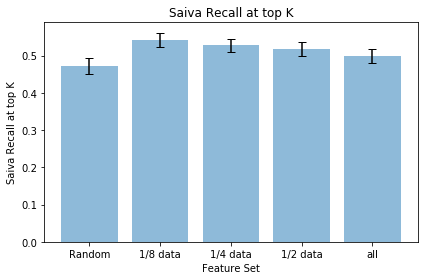

In [60]:
make_barplot('Saiva Recall at top K', all_stats_list, names)

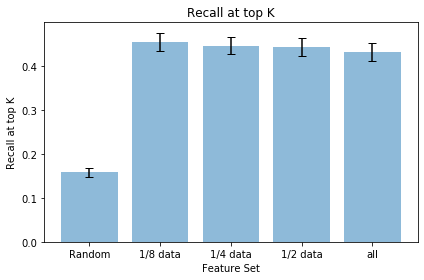

In [61]:
make_barplot('Recall at top K', all_stats_list, names)

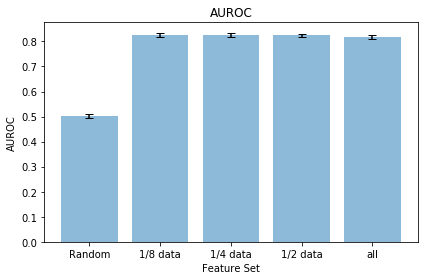

In [62]:
make_barplot('AUROC', all_stats_list, names)

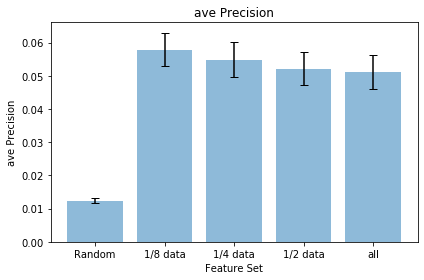

In [63]:
make_barplot('ave Precision', all_stats_list, names)